In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import os
import random
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets # 이미지 데이터셋 집합체
import torchvision.transforms as transforms # 이미지 변환 툴
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim # 최적화 알고리즘들이 포함힘
from collections import Counter

import albumentations as A
from albumentations import *
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import wandb

In [7]:
data = pd.read_csv("./data/classification_csv.csv")

In [8]:
good = data[data["class"] == 0]

In [12]:
good = good.sample(300)

In [13]:
data = data[data["class"] != 10]
data = data[data["class"] != 0]

In [14]:
data["class"].value_counts()

3    361
2    301
1    263
Name: class, dtype: int64

In [15]:
data = pd.concat([good,data], axis=0)

In [16]:
data["class"].value_counts()

3    361
2    301
0    300
1    263
Name: class, dtype: int64

In [19]:
train , valid = train_test_split(data, test_size=0.2, random_state=42, stratify=data["class"])

<AxesSubplot: ylabel='class'>

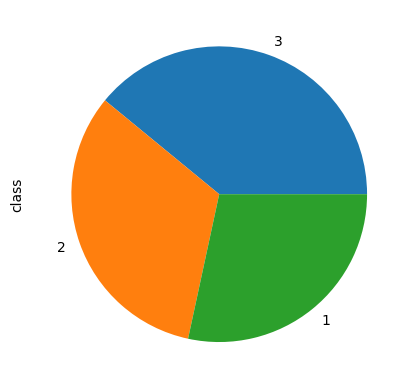

In [20]:
train["class"].value_counts().plot(kind="pie")

<AxesSubplot: ylabel='class'>

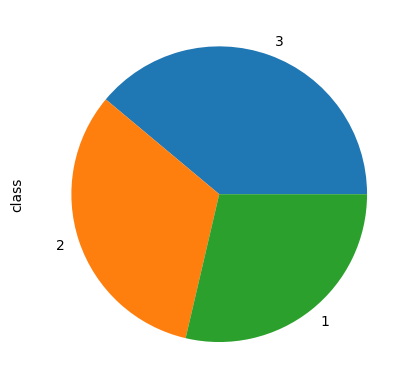

In [21]:
valid["class"].value_counts().plot(kind="pie")

#### Dataset & Data Loader

In [22]:
class ItemDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True, transforms=None):
        self.transforms = transforms
        self.train_mode = train_mode
        self.img_path_list = img_path_list
        self.label_list = label_list
    
    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        img = cv2.imread(img_path)
        
        if self.transforms is not None:
            img = self.transforms(image=img)["image"]
            
        if self.train_mode:
            label = self.label_list[index]
            return img, label
        else:
            return img
    def __len__(self):
        return len(self.img_path_list)

In [23]:
w ,h =  2464, 2056
# train_transform =A.Compose([
#                         A.Resize(always_apply=False, p=1.0,  height=h, width=w, interpolation=0),
#                         A.GaussNoise(always_apply=False, p=0.3, var_limit=(159.3, 204.6)),
#                         A.MotionBlur(always_apply=False, p=0.3, blur_limit=(8, 11)),
#                         A.OneOf([
#                             A.Rotate(always_apply=False, p=1.0, limit=(-14, 14), interpolation=0, border_mode=4, value=(0, 0, 0), mask_value=None),
#                             A.HorizontalFlip(always_apply=False, p=1.0),
#                                 ],p=0.5),
#                         A.OneOf([
#                             A.ElasticTransform(always_apply=False, p=1.0, alpha=1.0, sigma=50.0, alpha_affine=50.0, interpolation=0, border_mode=4, value=(0, 0, 0), mask_value=None, approximate=False),
#                             A.OpticalDistortion(always_apply=False, p=1.0, distort_limit=(-0.30, 0.30), shift_limit=(-0.05, 0.05), interpolation=0, border_mode=4, value=(0, 0, 0), mask_value=None),
#                             A.RandomResizedCrop(always_apply=False, p=1.0, height=h, width=w, scale=(0.5, 1.0), ratio=(0.75, 1.3), interpolation=0),
#                             A.RandomSizedCrop(always_apply=False, p=1.0, min_max_height=(h, h), height=h, width=w, w2h_ratio=1.0, interpolation=0),
#                             A.GridDistortion(always_apply=False, p=1.0, num_steps=5, distort_limit=(-0.3, 0.3), interpolation=0, border_mode=4, value=(0, 0, 0), mask_value=None),
#                                 ],p=0.3),
#                         A.OneOf([
#                             A.Equalize(always_apply=False, p=1.0, mode='cv', by_channels=True),
#                             A.HueSaturationValue(always_apply=False, p=1.0, hue_shift_limit=(-11, 11), sat_shift_limit=(-13, 13), val_shift_limit=(-15, 15))
#                                 ],p=0.3),             
#                         A.CoarseDropout(always_apply=False, p=0.5, max_holes=40, max_height=20, max_width=20, min_holes=40, min_height=14, min_width=14),
#                         A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#                         ToTensorV2()
#                             ])
train_transform = A.Compose([
                        A.Resize(always_apply=False, p=1.0, height=h, width=w, interpolation=0),
                        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ToTensorV2()
                            ])
test_transform = A.Compose([
                        A.Resize(always_apply=False, p=1.0, height=h, width=w, interpolation=0),
                        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ToTensorV2()
                            ])

In [24]:
train_dataset = ItemDataset(train["image_path"].tolist(), train["class"].tolist(), True, train_transform)
valid_dataset = ItemDataset(valid["image_path"].tolist(), valid["class"].tolist(), True, test_transform)

In [25]:
train_loader = DataLoader(train_dataset, batch_size = 128, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size = 128, shuffle=True, num_workers=4)

# Modeling

In [26]:
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')

if torch.cuda.is_available():    
    #device = torch.device("cuda:0")
    print('Device:', device)
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')
    
# Seed 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

Device: cuda:1
There are 2 GPU(s) available.
We will use the GPU: NVIDIA GeForce GTX 1080 Ti


In [27]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

Using cache found in /home/chicken/.cache/torch/hub/pytorch_vision_v0.10.0


In [28]:
model.fc = nn.Linear(in_features = 2048, out_features=3, bias=True)

In [30]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001)
scheduler = None
valid_counter = dict(valid["class"].value_counts())

In [ ]:
def train(model, optimizer, train_loader, valid_loader, scheduler, device, model_name):
    cnt = 0
    while True:
        try:
            if cnt ==0:
                os.mkdir(f"./models/{model_name}")
            else:
                os.mkdir(f"./models/{model_name}_{cnt}")
            break
        except:
            pass
        cnt += 1
            
    model.to(device)
    best_acc = 0
    metrics = {"Accuracy":[],"Precision":[],"Recall":[],"F1-Score":[]}
    # train
    for epoch in range(1,CFG["epochs"]+1):
        model.train()
        running_loss = 0.0
        
        for img, label in tqdm(iter(train_loader)):
            img, label = img.to(device), label.to(device)
            optimizer.zero_grad()
            
            pred = model(img)
            loss = criterion(pred, label)
            
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        print('[%d] Train loss: %.10f' %(epoch, running_loss / len(train_loader)))
        
        if scheduler is not None:
            scheduler.step()
            
        model.eval()

        valid_loss = 0.0
        correct = 0
        # valid
        with torch.no_grad():
            pred_list = []
            test_list = []
            for img, label in tqdm(iter(valid_loader)):
                img, label = img.to(device), label.to(device)

                pred = model(img)
                valid_loss += criterion(pred, label)
                pred = pred.argmax(dim=1, keepdim=True)
                pred_list.extend(pred.cpu().numpy())
                test_list.extend(label.cpu().numpy())

                correct += pred.eq(label.view_as(pred)).sum().item()
        valid_acc = 100 * correct / len(valid_loader.dataset)
        accuracy = accuracy_score(test_list, pred_list)
        precision = precision_score(test_list, pred_list, average="macro")
        recall = recall_score(test_list, pred_list, average="macro")
        f1 = f1_score(test_list, pred_list, average="macro")
        metrics["Accuracy"].append(accuracy)
        metrics["Precision"].append(precision)
        metrics["Recall"].append(recall)
        metrics["F1-Score"].append(f1)
        wandb.log({"Accuracy":accuracy, "Precision":precision, "Recall":recall, "F1-Score":f1})
        
        print(f"EPOCH_{epoch}accuracy : {accuracy}, precision : {precision}, recall : {recall}, f1_score : {f1}")
        if best_acc < valid_acc:
            best_acc = valid_acc
            torch.save(model.state_dict(), f'./models/{model_name}/{epoch}.pth') #이 디렉토리에 best_model.pth을 저장
            print('Model Saved.')
    return metrics

In [23]:
model_name = "fix_resnet50_128_drop_40"

In [ ]:
wandb.init()
wandb.run.name = model_name

In [24]:
metrics = train(model, optimizer, train_loader,valid_loader, scheduler, device, model_name)

100%|█████████████████████████████████████████| 373/373 [17:03<00:00,  2.74s/it]

[1] Train loss: 0.5878277081



100%|███████████████████████████████████████████| 94/94 [03:44<00:00,  2.39s/it]


EPOCH_1accuracy : 0.9662784852546917, precision : 0.9634579894584048, recall : 0.9681610884237761, f1_score : 0.9656598300595973
Model Saved.


100%|█████████████████████████████████████████| 373/373 [15:14<00:00,  2.45s/it]

[2] Train loss: 0.3070790105



100%|███████████████████████████████████████████| 94/94 [04:07<00:00,  2.63s/it]


EPOCH_2accuracy : 0.9877262064343163, precision : 0.9861278950973973, recall : 0.9889149261310975, f1_score : 0.9874828773565745
Model Saved.


100%|█████████████████████████████████████████| 373/373 [14:53<00:00,  2.39s/it]

[3] Train loss: 0.2162240080



100%|███████████████████████████████████████████| 94/94 [03:43<00:00,  2.37s/it]


EPOCH_3accuracy : 0.9887734584450402, precision : 0.9915018793923877, recall : 0.9860268364441804, f1_score : 0.9886901238881807
Model Saved.


100%|█████████████████████████████████████████| 373/373 [14:59<00:00,  2.41s/it]

[4] Train loss: 0.1708543372



100%|███████████████████████████████████████████| 94/94 [03:43<00:00,  2.38s/it]


EPOCH_4accuracy : 0.9952664209115282, precision : 0.9957863477232991, recall : 0.994734594619486, f1_score : 0.9952567105080286
Model Saved.


100%|█████████████████████████████████████████| 373/373 [21:51<00:00,  3.52s/it]

[5] Train loss: 0.1486362912



100%|███████████████████████████████████████████| 94/94 [06:06<00:00,  3.90s/it]


EPOCH_5accuracy : 0.9962298927613941, precision : 0.9968146463546051, recall : 0.9955516891214777, f1_score : 0.9961790405098501
Model Saved.


100%|█████████████████████████████████████████| 373/373 [14:55<00:00,  2.40s/it]

[6] Train loss: 0.1283919008



100%|███████████████████████████████████████████| 94/94 [03:44<00:00,  2.38s/it]


EPOCH_6accuracy : 0.9979892761394102, precision : 0.9980357106015432, recall : 0.997922725011095, f1_score : 0.9979784187831491
Model Saved.


100%|█████████████████████████████████████████| 373/373 [14:42<00:00,  2.37s/it]

[7] Train loss: 0.1140586973



100%|███████████████████████████████████████████| 94/94 [03:48<00:00,  2.43s/it]


EPOCH_7accuracy : 0.9962298927613941, precision : 0.9955727954206373, recall : 0.9961589304250178, f1_score : 0.9958608587890108


100%|█████████████████████████████████████████| 373/373 [15:19<00:00,  2.47s/it]

[8] Train loss: 0.1059813984



100%|███████████████████████████████████████████| 94/94 [03:41<00:00,  2.36s/it]


EPOCH_8accuracy : 0.9986176273458445, precision : 0.9986442064865575, recall : 0.9985596566196677, f1_score : 0.9986018549718099
Model Saved.


100%|█████████████████████████████████████████| 373/373 [14:59<00:00,  2.41s/it]

[9] Train loss: 0.0979459511



100%|███████████████████████████████████████████| 94/94 [03:46<00:00,  2.41s/it]


EPOCH_9accuracy : 0.9979892761394102, precision : 0.9983393270323869, recall : 0.9974692298109507, f1_score : 0.9979023865568868


100%|█████████████████████████████████████████| 373/373 [14:39<00:00,  2.36s/it]

[10] Train loss: 0.0932470897



100%|███████████████████████████████████████████| 94/94 [03:41<00:00,  2.36s/it]


EPOCH_10accuracy : 0.999078418230563, precision : 0.9990893127750522, recall : 0.9990720685588456, f1_score : 0.9990806218513618
Model Saved.


100%|█████████████████████████████████████████| 373/373 [15:01<00:00,  2.42s/it]

[11] Train loss: 0.0894148447



100%|███████████████████████████████████████████| 94/94 [03:51<00:00,  2.47s/it]


EPOCH_11accuracy : 0.9989108579088471, precision : 0.9988615786013428, recall : 0.998921364034943, f1_score : 0.9988912518434667


100%|█████████████████████████████████████████| 373/373 [15:05<00:00,  2.43s/it]

[12] Train loss: 0.0833109257



100%|███████████████████████████████████████████| 94/94 [03:43<00:00,  2.38s/it]


EPOCH_12accuracy : 0.9992459785522788, precision : 0.9990409200449297, recall : 0.9993029577611133, f1_score : 0.9991715836353329
Model Saved.


100%|█████████████████████████████████████████| 373/373 [15:35<00:00,  2.51s/it]

[13] Train loss: 0.0817633269



100%|███████████████████████████████████████████| 94/94 [03:48<00:00,  2.43s/it]


EPOCH_13accuracy : 0.9989527479892761, precision : 0.9987782694215608, recall : 0.9989678548730179, f1_score : 0.998872839196915


100%|█████████████████████████████████████████| 373/373 [15:08<00:00,  2.44s/it]

[14] Train loss: 0.0778244946



100%|███████████████████████████████████████████| 94/94 [03:50<00:00,  2.45s/it]


EPOCH_14accuracy : 0.9994135388739946, precision : 0.9992483765160384, recall : 0.9994803595864019, f1_score : 0.999364236033782
Model Saved.


100%|█████████████████████████████████████████| 373/373 [14:59<00:00,  2.41s/it]

[15] Train loss: 0.0746141197



100%|███████████████████████████████████████████| 94/94 [03:44<00:00,  2.39s/it]


EPOCH_15accuracy : 0.9988270777479893, precision : 0.9986728938035798, recall : 0.9989623791238602, f1_score : 0.9988169373756959


100%|█████████████████████████████████████████| 373/373 [14:49<00:00,  2.39s/it]

[16] Train loss: 0.0718768869



100%|███████████████████████████████████████████| 94/94 [03:45<00:00,  2.40s/it]


EPOCH_16accuracy : 0.9987851876675603, precision : 0.9988896931003417, recall : 0.9984593051190447, f1_score : 0.9986737529493614


100%|█████████████████████████████████████████| 373/373 [15:33<00:00,  2.50s/it]

[17] Train loss: 0.0667317582



100%|███████████████████████████████████████████| 94/94 [03:48<00:00,  2.43s/it]


EPOCH_17accuracy : 0.9993297587131368, precision : 0.9993033051823357, recall : 0.999353684069962, f1_score : 0.9993283875573968


100%|█████████████████████████████████████████| 373/373 [15:05<00:00,  2.43s/it]

[18] Train loss: 0.0671605146



100%|███████████████████████████████████████████| 94/94 [03:41<00:00,  2.36s/it]


EPOCH_18accuracy : 0.999036528150134, precision : 0.9988003979808898, recall : 0.9992538914033208, f1_score : 0.9990266142288682


100%|█████████████████████████████████████████| 373/373 [14:44<00:00,  2.37s/it]

[19] Train loss: 0.0669076713



100%|███████████████████████████████████████████| 94/94 [03:44<00:00,  2.39s/it]


EPOCH_19accuracy : 0.9992459785522788, precision : 0.9993076775977348, recall : 0.9990760235182565, f1_score : 0.999191411840135


100%|█████████████████████████████████████████| 373/373 [15:01<00:00,  2.42s/it]

[20] Train loss: 0.0618843789



100%|███████████████████████████████████████████| 94/94 [03:41<00:00,  2.36s/it]


EPOCH_20accuracy : 0.9993716487935657, precision : 0.9994100016098493, recall : 0.999278928753651, f1_score : 0.9993443965459587


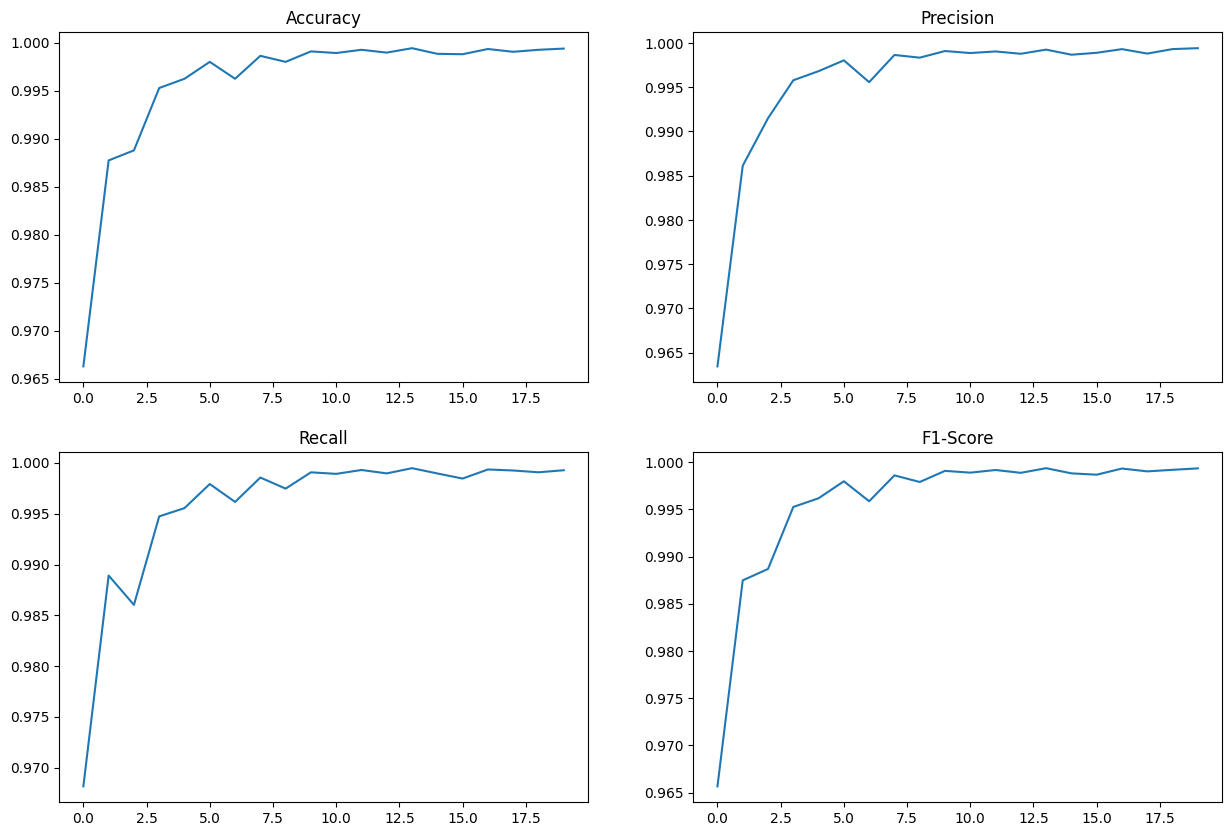

In [25]:
fig, axes = plt.subplots(2,2,figsize=(15,10))
axes = axes.flatten()

result = ["Accuracy", "Precision", "Recall", "F1-Score"]

for n,i in enumerate(result):
    axes[n].set_title(i)
    axes[n].plot(range(len(metrics[i])), metrics[i])

In [26]:
df = pd.DataFrame(metrics)
df.to_csv(f"./{model_name}_metrics.csv", index=False)